# Preamble

In [15]:
# Imports
## General
import numpy as np
import os
import sys
import warnings
import gc
warnings.filterwarnings('ignore')

## In order to run calculations on AWS GPU, need to explicitly specify CUDA lib directory in the environment variables
os.environ["XLA_FLAGS"]="--xla_gpu_cuda_data_dir=/home/sagemaker-user/.conda/envs/mlds_gpu"

## Data manipulation and preprocessing
import pandas as pd
import boto3
from tensorflow.keras.layers import StringLookup, Normalization

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

## Modelling
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint, EarlyStopping
import tensorflow as tf

## Import DeepCTR code
## This is done by cloning the github repository instead of installing with pip. This is because of an incompatibility issue
## with TF 2.14 that I had to manually fix in the DeepCTR code
deepctr_path = '/home/sagemaker-user/drl-ad-personalization/DeepCTR'
if deepctr_path not in sys.path:
    sys.path.append(deepctr_path)

from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names
from deepctr.models.dcn import DCN

## We want to be able to query the list of available adverts from athena, so we need a PyAthena connection
from pyathena import connect
conn = connect(s3_staging_dir='s3://mlds-final-project-bucket/athena_output/',
               region_name='eu-west-2')

# Preprocessing

In [16]:
# Create lists of categorical colums for each dataset
categorical_columns = [
    'DisplayURL',
    'AdID',
    'AdvertiserID',
    'QueryID',
    'KeywordID',
    'TitleID',
    'DescriptionID',
    'UserID'
]

# Import categorical feature mappings and define stringloohup objects for each dataset
stringlookups = {}
vocab_lengths = {}
for field in categorical_columns:
    df = pd.read_csv(f'./data/kdd12/categorical_value_counts/{field}.csv')
    vocab = [elem.encode() for elem in df['field'].astype(str).to_list()]
    lookup = StringLookup(vocabulary=vocab, mask_token=None)
    stringlookups.update({field:lookup})
    vocab_lengths.update({field:len(vocab)+1})

# Define numerical feature columns
numerical_columns = [
    'Depth',
    'Position'
]
# Extract scaler dicts for all datasets
dist_stats = pd.read_csv('./data/kdd12/means_variances.csv')
scalers = {}
for i in range(len(dist_stats)):
    field = dist_stats['field'][i]
    mean = dist_stats['mean'][i]
    variance = dist_stats['variance'][i]
    scaler = Normalization(mean=mean, variance=variance)
    scaler.build((1,))
    scalers.update({field:scaler})

In [17]:
## Define feature mappings
kdd12_fixlen_feature_columns = [SparseFeat(feat.lower(), vocabulary_size=vocab_lengths[feat], embedding_dim=4) for feat in categorical_columns]\
+ [DenseFeat(feat.lower(),1) for feat in numerical_columns]

## Generate the dnn and linear feature columns
kdd12_dnn_feature_columns = kdd12_fixlen_feature_columns
kdd12_linear_feature_columns = kdd12_fixlen_feature_columns

# Load Model

In [18]:
# Define the early stopping callback
earlystopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    start_from_epoch=5
)
# Define the precision, recall and auc metrics
precision = tf.keras.metrics.Precision(thresholds=0.5,name='precision')
recall = tf.keras.metrics.Recall(thresholds=0.5,name='recall')
auc = tf.keras.metrics.AUC(name='auc')

In [19]:
# Define function that returns compiled model
def get_model(
    dnn_hidden_units=[400,400],
    dnn_dropout=0.6,
    l2_reg_dnn=0.005,
    l2_reg_linear = 0.005,
    l2_reg_embedding=0.005,
    dnn_use_bn=True,
    cross_num=2
):
    model = DCN(
        kdd12_linear_feature_columns,
        kdd12_dnn_feature_columns,
        dnn_hidden_units=dnn_hidden_units,
        dnn_dropout=dnn_dropout,
        l2_reg_dnn=l2_reg_dnn,
        l2_reg_linear=l2_reg_linear,
        l2_reg_embedding=l2_reg_embedding,
        dnn_use_bn=dnn_use_bn,
        cross_num=cross_num,
    )
    
    # Compile the model
    model.compile(
        "adam", 
        "binary_crossentropy", 
        metrics=[
            'binary_crossentropy',
            'binary_accuracy',
            precision,
            recall,
            auc
        ],
    )

    return model

In [20]:
# Get the model
model = get_model()

CrossNet parameterization: vector


In [21]:
# Load the weights
model.load_weights('models/final_rl_model/rl_model.ckpt')

In [22]:
target_model = get_model()
target_model.set_weights(model.get_weights())

CrossNet parameterization: vector


# Define Reinfocement Learning environment

In [23]:
# Define RL env object that simpulates the Ad search platform
class RLenv:
    """
    Base class for Reinforcement Learning environment that simulates the search session
    """

    def __init__(self,):
        self.session_no = -1
        self.userid = ""
        self.queryid = ""
        self.adlist = pd.DataFrame()
        self.max_clicks = 0

    def newSession(self,):
        self.session_no += 1
        query_input = pd.read_sql(f"select userid, queryid from kdd12.offline_rl_queries where rn={str(self.session_no +1)}",conn)
        self.userid = query_input["userid"].values[0]
        self.queryid = query_input["queryid"].values[0]
        ad_list_df = pd.read_sql(f"select * from kdd12.offline_rl_testing where userid='{self.userid}' and queryid='{self.queryid}'",conn)
        ad_list_df['clicks'] = ad_list_df.clicks/ad_list_df.impression
        self.max_clicks = np.where(ad_list_df.clicks>=0.5,1.0,0.0).sum()
        self.adlist = ad_list_df.drop(columns=['impression']).sort_values(by=['clicks'],ascending=[False]).reset_index(drop=True)
        return self.adlist.copy().drop(columns=['clicks']), self.max_clicks

    def showAd(self, ad_index):
        ctr = self.adlist.loc[ad_index].clicks
        if ctr>=0.5:
            ctr_reward = 1.
        else:
            ctr_reward = 0.

        # return the CTR
        return ctr_reward

# Define preprocessing function

In [24]:
# Encode and Scale the datasets
def encode_scale(element):
    out = element.copy()
    for field in categorical_columns:
        out[field.lower()] = stringlookups[field](element[field.lower()])
    for field in numerical_columns:
        out[field.lower()] = tf.squeeze(scalers[field](element[field.lower()]),axis=-1)
    return out

In [25]:
# Define function for preprocessing the ad list
def preprocess(ad_list,batch_size=1):
    out_df = ad_list.copy()
    # Convert position and depth to floats
    out_df['position'] = out_df.position.astype('float32')
    out_df['depth'] = out_df.depth.astype('float32')
    # Convert to tf dataset
    tf_dataset = tf.data.Dataset.from_tensor_slices(dict(out_df))
    # Apply categorical encoding and numerical scaling
    tf_dataset = tf_dataset.map(encode_scale)
    # Add batch dim
    tf_dataset = tf_dataset.batch(batch_size)
    # Clean up
    del out_df
    return tf_dataset

In [26]:
# Encode and Scale the datasets
def encode_scale_2(element,labels):
    out = element.copy()
    for field in categorical_columns:
        out[field.lower()] = stringlookups[field](element[field.lower()])
    for field in numerical_columns:
        out[field.lower()] = tf.squeeze(scalers[field](element[field.lower()]),axis=-1)
    return out, labels

In [27]:
# Define function for preprocessing the ad list
def preprocess_2(ad_list,labels,batch_size=1):
    out_df = ad_list.copy()
    # Convert position and depth to floats
    out_df['position'] = out_df.position.astype('float32')
    out_df['depth'] = out_df.depth.astype('float32')
    # Convert to tf dataset
    tf_dataset = tf.data.Dataset.from_tensor_slices((dict(out_df),labels))
    # Apply categorical encoding and numerical scaling
    tf_dataset = tf_dataset.map(encode_scale_2)
    # Add batch dim
    tf_dataset = tf_dataset.batch(batch_size)
    # Clean up
    del out_df
    return tf_dataset

# Simulation Hyperparameters

In [28]:
# Set hyperparameters
K = 10 # Total episodes
L = 6 # session list Length
R = 10 # sessions per episode
H = L*R # Episode Time horizon
sample_size = 30
alpha = 1.0 # Explore network noise variable
gamma = 0.1 # Future value discount
current_episode = 0
memory = pd.DataFrame()
C = 5 # Target model update
current_session = 0

# Initialize the RL env
rl_env = RLenv()

if H%L>0:
    total_sessions = H//L +1
else:
    total_sessions = H//L

# RL Simulation

In [29]:
# Create rl_simlulation direcotry if it doesn't exist
if not os.path.exists('drl_simulation'):
    os.mkdir('drl_simulation')

In [35]:
for episode in range(K):
    print(f"---Episode {str(episode+1)} of {K}\n")
    
    # Initialize current stage and episode memory
    stage = 0
    episode_memory = pd.DataFrame()

    # Reset the target model if its time
    if (episode+1)%C == 0:
        print("Resetting target model")
        target_model = get_model()
        target_model.set_weights(model.get_weights())

    # Run minor update algorithm after each session
    for session in range(R):
        print(f"Starting session {str(session+1)} of {str(R)} at stage {str(stage+1)}")
        
        # Initialize new session
        session_ad_list, session_max_clicks = rl_env.newSession()
        
        # Create the explore model
        explore_model = get_model()
        explore_model.set_weights(model.get_weights())
        for layer in explore_model.trainable_weights:
            noise = tf.multiply(tf.multiply(alpha,tf.random.uniform(shape=layer.shape,minval=-1., maxval=1.)),layer)
            layer.assign_add(noise)
        
        # Add base, target and explore model scoring to the session ad list
        pred_features = [
            'displayurl',
            'adid',
            'advertiserid',
            'position',
            'depth',
            'keywordid',
            'titleid',
            'descriptionid',
            'queryid',
            'userid'
        ]
        session_ad_ds = preprocess(session_ad_list)
        session_ad_list['base_score'] = model.predict(session_ad_ds, verbose=False)
        session_ad_list['explore_score'] = explore_model.predict(session_ad_ds, verbose=False)
        session_ad_list['target_score'] = target_model.predict(session_ad_ds, verbose=False)
        
        stages = []
        sessions = []
        episodes = []
        actions = []
        clicks = []
        Q_futures = []
        selection_models = []
        list_data = pd.DataFrame(columns=pred_features)
        for pos in range(L):
            Q_future = session_ad_list[session_ad_list.base_score == session_ad_list.base_score.max()].head(1).target_score.values[0]
            Q_futures.append(Q_future)
            selection_model = np.random.choice(['base','explore'],size=1)[0]
            selection_models.append(selection_model)
            if selection_model == 'base':
                next_action = session_ad_list[session_ad_list.base_score == session_ad_list.base_score.max()].head(1).index.values[0]
            else:
                next_action = session_ad_list[session_ad_list.explore_score == session_ad_list.explore_score.max()].head(1).index.values[0]
            actions.append(next_action)
            list_data.loc[pos] = session_ad_list.loc[next_action]
            click = rl_env.showAd(next_action)
            clicks.append(click)
            session_ad_list = session_ad_list.loc[session_ad_list.index != next_action]
            stages.append(stage)
            sessions.append(session)
            episodes.append(episode)
            stage += 1
        
        list_data['stage'] = stages
        list_data['session'] = sessions
        list_data['episode'] = episodes
        list_data['session_max_clicks'] = [session_max_clicks]*L
        list_data['action']=actions
        list_data['click']=clicks
        list_data['Q_future']=Q_futures
        list_data['selection_model']=selection_models
        list_data = list_data.reset_index(names='list_pos')
        if list_data[list_data.selection_model == "explore"].click.mean() > list_data[list_data.selection_model == "base"].click.mean():
            print("Explore session outperformed base model. Setting model weights...")
            model.set_weights(explore_model.get_weights())

        # Concatinate list data to episode memory
        episode_memory = pd.concat([episode_memory,list_data],ignore_index=True)
    
    # Calculate the total reward
    episode_memory['reward'] = (1. - gamma)*episode_memory.click + gamma*episode_memory.Q_future.shift(-1).fillna(0.0)

    # Concatinate episode memory to total memory
    memory = pd.concat([memory, episode_memory], ignore_index=True)

    # Execute major update using experience replay
    memory_sample = memory.sample(sample_size)
    model_input_ds = preprocess_2(memory_sample[pred_features],memory_sample.reward.to_numpy(),batch_size=sample_size)
    model.fit(model_input_ds)

# Export the memory data
print("Simulation complete. Exporting data...")
memory.to_csv('drl_simulation/drl_memory.csv',index=False)
print("Complete")

---Episode 1 of 10

Starting session 1 of 10 at stage 1
CrossNet parameterization: vector
Starting session 2 of 10 at stage 7
CrossNet parameterization: vector
Starting session 3 of 10 at stage 13
CrossNet parameterization: vector
Starting session 4 of 10 at stage 19
CrossNet parameterization: vector
Starting session 5 of 10 at stage 25
CrossNet parameterization: vector
Starting session 6 of 10 at stage 31
CrossNet parameterization: vector
Starting session 7 of 10 at stage 37
CrossNet parameterization: vector
Starting session 8 of 10 at stage 43
CrossNet parameterization: vector
Starting session 9 of 10 at stage 49
CrossNet parameterization: vector
Starting session 10 of 10 at stage 55
CrossNet parameterization: vector
1/1 [==============================] - 4s 4s/step - loss: 0.2022 - binary_crossentropy: 0.1728 - binary_accuracy: 0.0333 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.8103
---Episode 2 of 10

Starting session 1 of 10 at stage 1
CrossNet parameterization: vector
S

# RL Simulation Result Analysis

In [1]:
# Imports
## General
import numpy as np
import os
import sys
import warnings
import gc
warnings.filterwarnings('ignore')

## Data manipulation and preprocessing
import pandas as pd
import boto3

## Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, Image

In [3]:
# Read in the DRL memory data as a pandas dataframe
memory_df = pd.read_csv('./drl_simulation/drl_memory.csv')
memory_df.head()

,list_pos,displayurl,adid,advertiserid,position,depth,keywordid,titleid,descriptionid,queryid,userid,stage,session,episode,session_max_clicks,action,click,Q_future,selection_model,reward
0,0,14340390157469404125,9027549,23808,1,1,148671,27,14,18,1071867,0,0,0,0.0,4,0.0,0.072733,explore,0.007121
1,1,14340390157469404125,9027557,23808,1,1,2385,552,14,18,1071867,1,0,0,0.0,0,0.0,0.071215,explore,0.007121
2,2,14340390157469404125,9027557,23808,1,1,2465,552,14,18,1071867,2,0,0,0.0,1,0.0,0.071215,base,0.007106
3,3,14340390157469404125,9027554,23808,1,1,3497,541,14,18,1071867,3,0,0,0.0,2,0.0,0.071057,base,0.007105
4,4,14340390157469404125,9027554,23808,1,1,2318,541,14,18,1071867,4,0,0,0.0,5,0.0,0.071055,explore,0.004373


In [5]:
# Group by episode and session, max_clicks, sum the clicks
session_memory = memory_df.groupby(['session','episode','session_max_clicks']).agg({'click':'sum'}).reset_index()
session_memory.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   session             100 non-null    int64  
 1   episode             100 non-null    int64  
 2   session_max_clicks  100 non-null    float64
 3   click               100 non-null    float64
dtypes: float64(2), int64(2)
memory usage: 3.3 KB


In [15]:
# Cap the session max clicks to 10

cap = [10.]*100
session_memory['session_max_clicks']= np.where(session_memory.session_max_clicks > cap, cap, session_memory.session_max_clicks)

In [20]:
session_memory['regret'] = session_memory['session_max_clicks'] - session_memory['click']

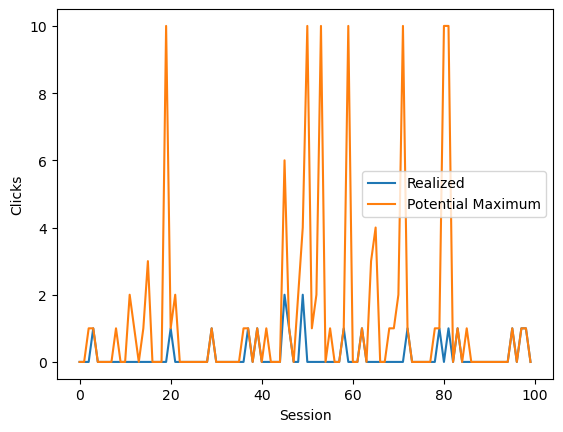

In [18]:
# Plot the clicks and the session max clicks

plt.plot(np.arange(100), session_memory.click, label = 'Realized')
plt.plot(np.arange(100), session_memory.session_max_clicks, label = 'Potential Maximum')
plt.xlabel('Session')
plt.ylabel('Clicks')
plt.legend()
plt.show()

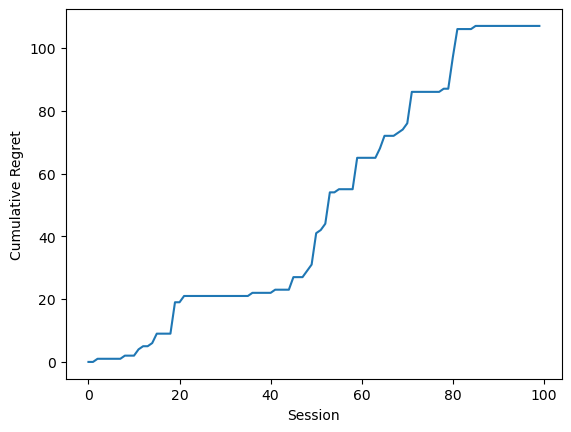

In [21]:
# Plot the Cumulative Regret
plt.plot(np.arange(100),session_memory.regret.to_numpy().cumsum())
plt.xlabel('Session')
plt.ylabel('Cumulative Regret')
plt.show()
